In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
import os

cwd = os.getcwd()
cwd
benchmark_result_path = os.path.realpath(
    os.path.join(cwd, "../data/realworld-results.csv")
)
benchmark_result_path

'/Users/csalih/Developer/bsc-web-benchmark/benchmark/benchmark-analyze/data/realworld-results.csv'

In [3]:
# Load the dataset
csv_headers = ["framework", "os", "browser", "metric", "rating", "value"]
df = pd.read_csv(benchmark_result_path, header=None, names=csv_headers)

# Group the data
frameworks = df["framework"].unique()
metrics = df["metric"].unique()
browsers = df["browser"].unique()
operating_systems = df["os"].unique()

df_by_framework = df.groupby("framework")
df_by_metric = df.groupby("metric")

# Display basic info
pd.concat([df.head(5), df.tail(5)])

,framework,os,browser,metric,rating,value
0,realworld-angular,darwin,chromium,TTFB,good,6.3
1,realworld-angular,darwin,chromium,FCP,good,52.0
2,realworld-angular,darwin,chromium,FID,good,1.6
3,realworld-angular,darwin,chromium,LCP,good,80.0
4,realworld-angular,darwin,chromium,TTFB,good,3.6
126722,realworld-vue,win32,webkit,FCP,good,362.0
126723,realworld-vue,win32,webkit,TTFB,good,3.0
126724,realworld-vue,win32,webkit,FCP,good,389.0
126725,realworld-vue,win32,webkit,TTFB,good,3.0
126726,realworld-vue,win32,webkit,FCP,good,395.0


In [4]:
# Validate

# Check if there is sufficient data for ANOVA
if (
    df["framework"].nunique() < 0
    or df["browser"].nunique() < 0
    or df["os"].nunique() < 0
):
    raise Exception(f"Metric {metric} has insufficient data.")


# Group by all factors and count the number of observations
counts = (
    df.groupby(["framework", "metric", "browser", "os"])
    .size()
    .reset_index(name="count")
)
single_observations = counts[counts["count"] == 1]

if not single_observations.empty:
    print("WARNING: The following groups have only one observation. ANOVA may fail:")
    print(single_observations)
    raise Exception("Consider combining levels or simplifying your model.")

In [5]:
# Initialize a results dictionary
anova_results = {}

for metric, group_df in df_by_metric:
    # Perform ANOVA for the metric
    model = ols("value ~ C(framework)", data=group_df).fit()
    anova_results[metric] = sm.stats.anova_lm(model, typ=1)

    print("######################################################################")
    print(f"ANOVA Results for Metric: {metric}")
    print("######################################################################")
    print(anova_results[metric])
    print("")

######################################################################
ANOVA Results for Metric: FCP
######################################################################
                   df        sum_sq       mean_sq            F  PR(>F)
C(framework)      3.0  6.121718e+07  2.040573e+07  1171.926317     0.0
Residual      38994.0  6.789684e+08  1.741213e+04          NaN     NaN

######################################################################
ANOVA Results for Metric: FID
######################################################################
                   df       sum_sq     mean_sq           F         PR(>F)
C(framework)      3.0   473.211396  157.737132  441.443453  1.926138e-279
Residual      24828.0  8871.572315    0.357321         NaN            NaN

######################################################################
ANOVA Results for Metric: LCP
######################################################################
                   df        sum_sq       mean_

######################################################################
Tukey Results for Metric: FCP
######################################################################
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1           group2      meandiff p-adj   lower    upper   reject
---------------------------------------------------------------------------
realworld-angular realworld-leptos  83.0425   0.0   78.3149    87.77   True
realworld-angular  realworld-react -12.8453   0.0  -17.8993  -7.7914   True
realworld-angular    realworld-vue   9.0843   0.0    4.0304  14.1383   True
 realworld-leptos  realworld-react -95.8878   0.0 -100.6151 -91.1605   True
 realworld-leptos    realworld-vue -73.9581   0.0  -78.6854 -69.2308   True
  realworld-react    realworld-vue  21.9296   0.0    16.876  26.9833   True
---------------------------------------------------------------------------
####################################################################

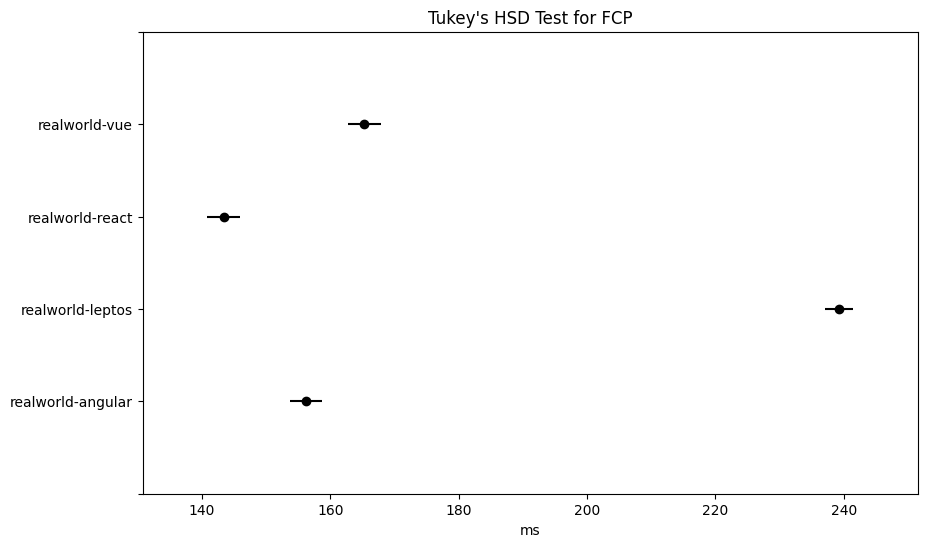

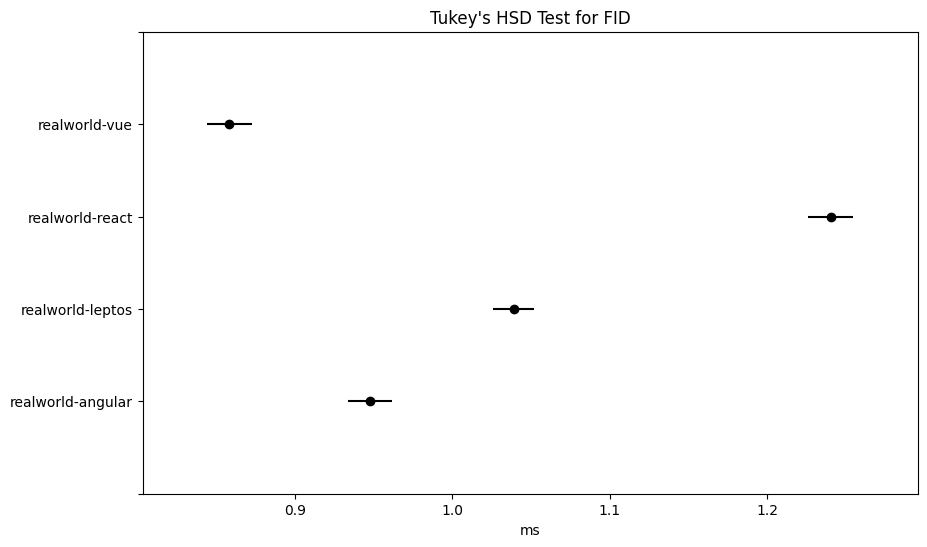

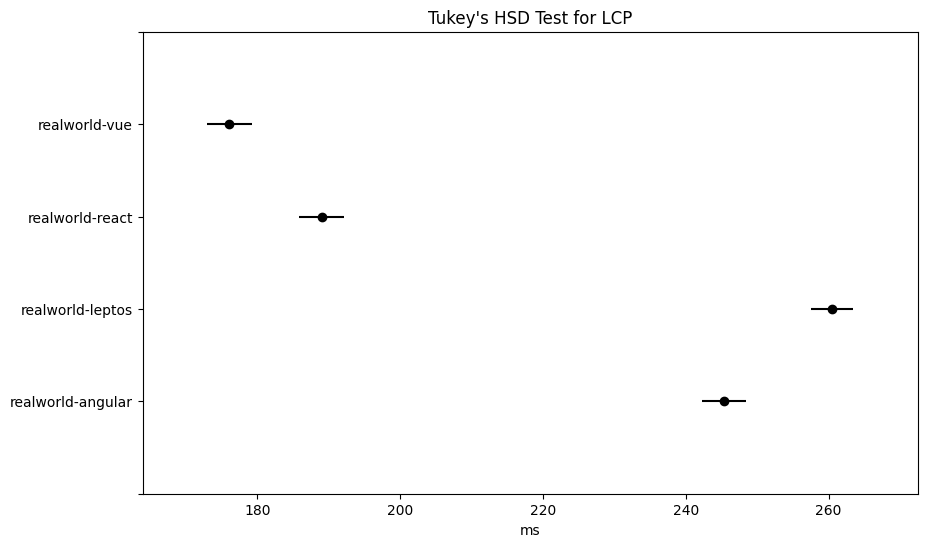

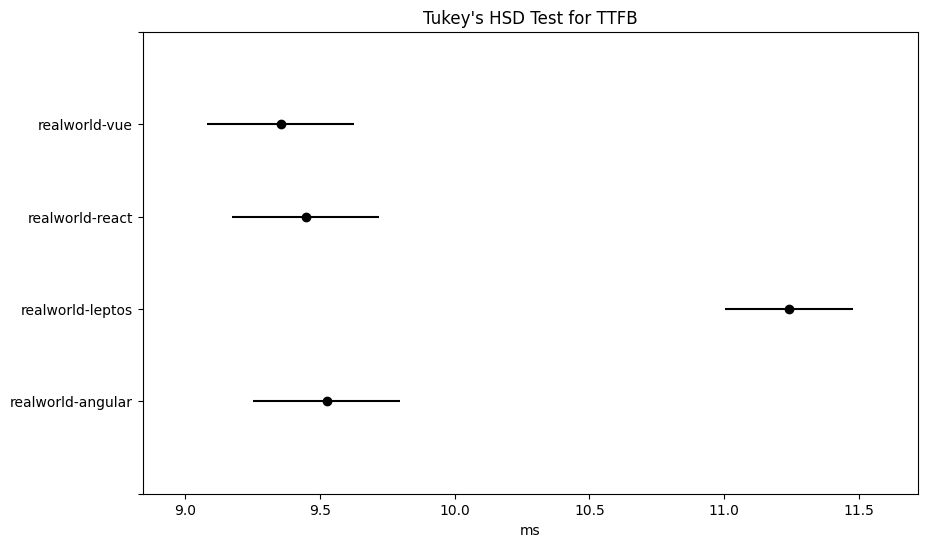

In [6]:
alpha = 0.05

for metric, group_df in df_by_metric:
    endog = group_df["value"]  # Data
    groups = group_df["framework"]  # Groups

    tukey = pairwise_tukeyhsd(endog, groups, alpha)

    print("######################################################################")
    print(f"Tukey Results for Metric: {metric}")
    print("######################################################################")
    print(tukey.summary())

    # Plot group confidence intervals
    fig, ax = plt.subplots(figsize=(1, 1))
    tukey.plot_simultaneous(ax=ax, xlabel="ms")
    # plt.vlines(x=50, ymin=-0.5, ymax=4.5, color="red")

    ax.set_title(f"Tukey's HSD Test for {metric}")